<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>From tensorflow experiment to scoring with</b></font><font face="monospace" size="4" color="darkblue"><b> watson-machine-learning-client</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning experiments to train Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Training definition](#definition)
3.	[Experiment definition](#experiment)
4.	[Experiment Run](#run)
5.	[Deploy and Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered).
    - After you create COS instance, go to your COS dashboard.
    - In "Service credentials" tab, click on "New Credential",
    - Add inline configuration parameter: {"HMAC":true}, click "Add".

    This configuration parameter will add section below to instance credentials which will be used later on,
    ```
      "cos_hmac_keys": {
            "access_key_id": "722432c254bc4eaa96e05897bf2779e2",
            "secret_access_key": "286965ac10ecd4de8b44306288c7f5a3e3cf81976a03075c"
       }
    ```

### 1.1 Working with Cloud Object Storage

Boto library allows Python developers to manage Cloud Object Storage.

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time
warnings.filterwarnings('ignore')

We define the endpoint we will use. You can find this information in "Endpoint" section of your Cloud Object Storage intance's dashbord.

In [4]:
{
  "apikey": "JmksB4QxMMNyMGlbwwr928uHjKxtBofjayoPXx8w3Tfq",
  "cos_hmac_keys": {
    "access_key_id": "20691e7796494a55b0086763eeece00c",
    "secret_access_key": "9fca51949d9af2e6fc9511d5caff9382b6edd2807334672c"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/298cbf9f271000e4aedc4937e76bc54f:7e6b5d78-9372-4c21-b43b-4a31bf63c7db::",
  "iam_apikey_name": "auto-generated-apikey-20691e77-9649-4a55-b008-6763eeece00c",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/298cbf9f271000e4aedc4937e76bc54f::serviceid:ServiceId-c3a39f3e-e9d0-4f20-9431-b39440bd3351",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/298cbf9f271000e4aedc4937e76bc54f:7e6b5d78-9372-4c21-b43b-4a31bf63c7db::"
},

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

NameError: name 'cos_credentials' is not defined

We create Boto resource by providing type, endpoint_url and credentials.

In [7]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets we will use to store training data and training results.

In [9]:
uuid = '0b6446ce-bfc1-442c-932a-98949628bb49'
buckets = ['train-data-experiment-' + uuid, 'train-result-experiment-' + uuid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "train-data-experiment-0b6446ce-bfc1-442c-932a-98949628bb49"...
Creating bucket "train-result-experiment-0b6446ce-bfc1-442c-932a-98949628bb49"...


Now we should have 2 new buckets created.

In [14]:
print([bkt.name for bkt in list(cos.buckets.all()) if uuid in bkt.name])

['train-data-experiment-0b6446ce-bfc1-442c-932a-98949628bb49', 'train-result-experiment-0b6446ce-bfc1-442c-932a-98949628bb49']


### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [15]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

Below snippet will create 'MNIST_DATA' folder and download the files from links.

**Tip:** First, please install wget library by the command below
`!pip install wget`

In [16]:
import wget, os

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

for link in data_links:
    if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
        wget.download(link, out=data_dir)  
        
!ls MNIST_DATA

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Upload the data files to created buckets.

In [17]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

t10k-labels-idx1-ubyte.gz is uploaded.
train-images-idx3-ubyte.gz is uploaded.
train-labels-idx1-ubyte.gz is uploaded.
t10k-images-idx3-ubyte.gz is uploaded.


Let's see the list of all buckets and their contents.

In [18]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: t10k-images-idx3-ubyte.gz
Object size (kb): 1610.2314453125
Object key: t10k-labels-idx1-ubyte.gz
Object size (kb): 4.435546875
Object key: train-images-idx3-ubyte.gz
Object size (kb): 9680.099609375
Object key: train-labels-idx1-ubyte.gz
Object size (kb): 28.2041015625


We are done with Cloud Object Storage, we are ready to train our model!

### 1.3 Work with the Watson Machine Learning instance

Authenticate to Watson Machine Learning service on Bluemix.

In [5]:
import urllib3, requests, json, base64, time, os

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [6]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "ZGbdxBvCCm1wnXdvwAtDqF+KQWbSX3dnSXRhka9qiGd6PJT+Xl8OYfwfpdjfDieJHxGxQ3pIogjgEOjN0TGDTcL0h32gVzPkwMbmHXNpi+FQYUqQmv73SQJrb1WXWeZv",
  "username": "e2146647-22fa-4b13-9540-9e6de422cc2e",
  "password": "1555668d-3796-4b1c-bba4-95e54bc5c1ec",
  "instance_id": "264a32df-c5d5-48a4-9129-d12e8911ebdf"
}

#### Install `watson-machine-learning-client` from pypi

In [7]:
!pip install --upgrade watson-machine-learning-client==0.3.701

    100% |████████████████████████████████| 450kB 2.3MB/s eta 0:00:01
Requirement already up-to-date: tabulate in /usr/local/src/conda3_runtime.v27/4.1.1/lib/python3.5/site-packages (from watson-machine-learning-client==0.3.701)
    100% |████████████████████████████████| 61kB 6.1MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 6.3MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 5.4MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 25.7MB 46kB/s  eta 0:00:01
    100% |████████████████████████████████| 143kB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 5.8MB/s eta 0:00:01
    100% |████████████████████████████████| 194kB 4.2MB/s eta 0:00:01
    100% |████████████████████████████████| 17.1MB 70kB/s  eta 0:00:01   55% |█████████████████▊              | 9.5MB 48.0MB/s eta 0:00:01
    100% |████████████████████████████████| 512kB 2.3MB/s eta 0:00:01


**Tip**: If above install fails due to "AssertionError: Multiple .dist-info ...", please uninstall client library and remove the build directory with the commands below, then run the pip install again.

`!rm -rf /tmp/<directory-id-found-in-error>/pip-build/watson-machine-learning-client`

where for example, directory-id: s130-c0573632d58e90-35c9a7ecf27a



#### Import `watson-machine-learning-client` and authenticate to service instance

In [8]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [9]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [10]:
print(client.version)

0.3.701


<a id="definition"></a>
## 2. Training definitions

### 2.2 Save training definition 

#### Prepare training definition metadata

In [11]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "definition tf 1.2",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "js@js.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.2",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

In [12]:
model_definition_2_metadata = {
            client.repository.DefinitionMetaNames.NAME: "definition with metrics tf 1.3",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: "js@js.com",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.3",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 convolutional_network.py --trainImagesFile ${DATA_DIR}/train-images-idx3-ubyte.gz --trainLabelsFile ${DATA_DIR}/train-labels-idx1-ubyte.gz --testImagesFile ${DATA_DIR}/t10k-images-idx3-ubyte.gz --testLabelsFile ${DATA_DIR}/t10k-labels-idx1-ubyte.gz --learningRate 0.001 --trainingIters 20000"
            }

#### Get sample model definition content files from git

In [13]:
filename_softmax = 'tf-softmax-model.zip'
filename_cnn = 'tf-model-metrics.zip'

if os.path.isfile(filename_softmax):
    !ls tf-softmax-model.zip
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
    !ls tf-softmax-model.zip
    
if os.path.isfile(filename_cnn):
    !ls tf-model-metrics.zip
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-model-metrics.zip
    !ls tf-model-metrics.zip

--2018-02-07 08:58:34--  https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip [following]
--2018-02-07 08:58:34--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3847 (3.8K) [application/zip]
Saving to: ‘tf-softmax-model.zip’

100%[===========

#### Publish training definition in Watson Machine Learning repository

##### Store definition 1

In [14]:
definition_details = client.repository.store_definition(filename_softmax, model_definition_metadata)

definition_url = client.repository.get_definition_url(definition_details)
definition_uid = client.repository.get_definition_uid(definition_details)
print(definition_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/5f6ae2fc-a872-473d-8629-8cad0bc8aab4


##### Store definition 2

In [15]:
definition_2_details = client.repository.store_definition(filename_cnn, model_definition_2_metadata)

definition_2_url = client.repository.get_definition_url(definition_2_details)
definition_2_uid = client.repository.get_definition_uid(definition_2_details)
print(definition_2_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/f481e63a-6403-4445-8545-d057c4f561e8


#### LIST stored definitions

In [16]:
client.repository.list_definitions()

------------------------------------  ------------------------------  ------------------------  ----------  ----------
GUID                                  NAME                            CREATED                   FRAMEWORK   TYPE
5f6ae2fc-a872-473d-8629-8cad0bc8aab4  definition tf 1.2               2018-02-07T14:58:42.824Z  tensorflow  definition
f481e63a-6403-4445-8545-d057c4f561e8  definition with metrics tf 1.3  2018-02-07T14:58:47.680Z  tensorflow  definition
------------------------------------  ------------------------------  ------------------------  ----------  ----------


<a id="experiment"></a>
## 3. Experiment definition

### 3.1 Save experiment

#### Get the list of supported configuration params

In [17]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
AUTHOR_NAME                 str   N
AUTHOR_EMAIL                str   Y
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  Y
TRAINING_REFERENCES         json  Y
TRAINING_DATA_REFERENCE     json  Y
TRAINING_RESULTS_REFERENCE  json  Y
--------------------------  ----  --------


#### Experiment configuration dictionary
Create experiment that will train two models based on previously stored definitions.

In [18]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "MNIST experiment",
            client.repository.ExperimentMetaNames.DESCRIPTION: "mnist best model",
            client.repository.ExperimentMetaNames.AUTHOR_EMAIL: "zawisza@ibm.com",
            client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["accuracy"],
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
                        },
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "target": {
                                "bucket": buckets[1],
                            },
                            "type": "s3"
                        },
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "mnist_nn",
                            "training_definition_url": definition_url,
                        },
                        {
                            "name": "mnist_cnn",
                            "training_definition_url": definition_2_url,
                            "compute_configuration": {"name": "small"}
                        },
                    ],
                }

NameError: name 'service_endpoint' is not defined

#### Store experiment in Watson Machine Learning repository

In [33]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

92fc5618-db9c-4121-80d7-ed3f4552c0b1


#### LIST stored experiments

In [34]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------  ---------  ----------
GUID                                  NAME              CREATED                   FRAMEWORK  TYPE
92fc5618-db9c-4121-80d7-ed3f4552c0b1  MNIST experiment  2018-02-01T12:55:34.049Z  -          experiment
------------------------------------  ----------------  ------------------------  ---------  ----------


#### UPDATE experiment
You can update experiment definition by calling below method.

#### GET experiment definition details

In [35]:
details = client.repository.get_experiment_details(experiment_uid)

#### Delete experiment definition from repository

<a id="run"></a>
## 4. Run experiment

### 4.1 Run experiment

**Tip:** To run experiment in background set optional parameter `asynchrounous=True` (or remove it)

In [36]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=False)



#############################################################

Running 'df109248-070c-43e9-aa40-f18169e1dbe6' experiment run

#############################################################




------------------------------
'training-IQ3NoFCkg' run (1/2)
------------------------------




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 10.419174671173096 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 20.58488655090332 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Elapsed time: 30.92478895187378 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 41.105644941329956 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Elapsed time: 52.745896339416504 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Elapsed time: 62.98328375816345 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Elapsed time: 73.21103596687317 -> training state: pending



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 83.35318779945374 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 93.54684019088745 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 103.72801327705383 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 113.89347219467163 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 124.07702994346619 -> training state: completed



------------------------------
'training-TRNvoKCkR' run (2/2)
------------------------------





100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 134.25892114639282 -> training state: pending




100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Elapsed time: 144.46589422225952 -> training state: completed



--------------------------------------------------------------------
Run of 'df109248-070c-43e9-aa40-f18169e1dbe6' finished successfully.
--------------------------------------------------------------------




As we can see experiment run has fininshed.

#### GET experiment run UID

In [37]:
experiment_run_id = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_id)

df109248-070c-43e9-aa40-f18169e1dbe6


#### GET experiment details
Use below method to get all information about particular experiment.

In [38]:
experiment_details = client.experiments.get_details(experiment_uid)

You can use below print method to display experiment details (change cell type to code).

#### GET run details
Use below method to get particular experiment run details.

In [39]:
run_details = client.experiments.get_run_details(experiment_run_id)

#### GET experiment run status
You can check experiment run status by calling `client.experiments.get_status(run_uid)` method. This is quite useful when running experiment in background.

In [40]:
status = client.experiments.get_status(experiment_run_id)
print(status)

{'submitted_at': '2018-02-01T12:56:27Z', 'state': 'completed', 'current_iteration': 1, 'current_at': '2018-02-01T12:56:27Z'}


#### MONITOR experiment run
You can monitor experiment run by calling `client.experiments.monitor_logs(run_uid)`. This method will stream training logs content to console.

In [41]:
client.experiments.monitor_logs(experiment_run_id)



########################################################################

Monitor started for experiment run: df109248-070c-43e9-aa40-f18169e1dbe6

########################################################################




------------------
training-IQ3NoFCkg
------------------


*** Begin Log History for training-IQ3NoFCkg ***
Training with training/test data at:
DATA_DIR: /job/train-data-experiment-0b6446ce-bfc1-442c-932a-98949628bb49
MODEL_DIR: /job/model-code
TRAINING_JOB:
TRAINING_COMMAND: python3 tensorflow_mnist_softmax.py --trainingIters 20
Storing trained model at:
RESULT_DIR: /job/train-result-experiment-0b6446ce-bfc1-442c-932a-98949628bb49
BAZEL_VERSION=0.4.5
CI_BUILD_PYTHON=python3
CUDA_PKG_VERSION=8-0=8.0.61-1
CUDA_VERSION=8.0.61
CUDNN_VERSION=5.1.10
DATA_DIR=/job/train-data-experiment-0b6446ce-bfc1-442c-932a-98949628bb49
GPU_COUNT=1.000000
HOME=/root
tensor_shape {
dim {
size: -1
}
}
}
}
method_name: "tensorflow/serving/classify"
*** End Log History for training-IQ3N

You can also monitor training quality metrics during experiment run.

In [42]:
client.experiments.monitor_metrics(experiment_run_id)



###############################################################################

Metric monitor started for experiment run: df109248-070c-43e9-aa40-f18169e1dbe6

###############################################################################




--------------------
Metric monitor done.
--------------------




#### LIST experiment runs
You can list experiment run using `client.experiments.list()` method.

In [43]:
client.experiments.list()

------------------------------------  ------------------------------------  -----------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE      CREATED
92fc5618-db9c-4121-80d7-ed3f4552c0b1  df109248-070c-43e9-aa40-f18169e1dbe6  MNIST experiment   completed  2018-02-01T12:56:11Z
------------------------------------  ------------------------------------  -----------------  ---------  --------------------


#### LIST training runs trigered by experiment run

In [44]:
client.experiments.list_training_runs(experiment_run_id)

------------------  ---------  ---------  --------------------  --------------------  -----------
GUID (training)     NAME       STATE      SUBMITTED             FINISHED              PERFORMANCE
training-IQ3NoFCkg  mnist_nn   completed  2018-02-01T12:56:20Z  2018-02-01T12:58:20Z
training-TRNvoKCkR  mnist_cnn  completed  2018-02-01T12:56:26Z  2018-02-01T12:58:41Z
------------------  ---------  ---------  --------------------  --------------------  -----------


#### GET training runs detais

In [45]:
training_runs_details = client.experiments.get_training_runs(experiment_run_details)

#### GET training runs uids

In [46]:
training_run_uids = client.experiments.get_training_uids(experiment_run_details)

for i in training_run_uids:
    print(i)

training-IQ3NoFCkg
training-TRNvoKCkR


<a id="model"></a>
### 4.2 Store trained model

#### Call this method to save model in Watson Machine Learning repository

In [47]:
saved_model_details = client.repository.store_model(str(training_run_uids[0]), {'name': 'Mnist model'})

**Tip:** Run below code to extract stored model guid from dictionary.

In [48]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: 21ee66aa-bf2a-421e-bb18-ade3f802e46d


#### Call this method to list stored models

In [49]:
client.repository.list_models()

------------------------------------  ----------------------------  ------------------------  -----------------  -----
GUID                                  NAME                          CREATED                   FRAMEWORK          TYPE
d11edd8b-a8b9-4dde-8634-77a29ffa6434  Tumor_Type_Detection_v1_pipe  2018-01-31T14:46:00.929Z  scikit-learn-0.17  model
7d29c62d-61cc-4876-9260-7b48210e7b2c  my_model                      2018-02-01T09:58:47.788Z  tensorflow-1.4     model
7fac9a8d-242e-4964-89e2-510b7a765cb7  my_model                      2018-02-01T10:18:22.141Z  tensorflow-1.4     model
db69150c-bf42-4c6b-ba9e-5cbb5680f5ba  my_model                      2018-02-01T10:21:32.372Z  tensorflow-1.2     model
fec67854-488f-49a4-a437-b1b5732d78b8  My cool mnist model           2018-02-01T11:28:19.402Z  tensorflow-1.2     model
21ee66aa-bf2a-421e-bb18-ade3f802e46d  Mnist model                   2018-02-01T13:00:30.407Z  tensorflow-1.2     model
------------------------------------  -----------

### 4.3 Delete experiment-run

You can delete experiment runs and results by running below method.

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

In [50]:
deployment_details = client.deployments.create(name="Mnist model deployment", model_uid=model_guid)

In [51]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/fd1db635-c9f3-4d83-afc7-32efec367e5e/published_models/21ee66aa-bf2a-421e-bb18-ade3f802e46d/deployments/1616b19b-bd4c-4e77-b29f-fbe235497a35/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [58]:
image1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,0.757,0.596,0.361,0.200,0.200,0.200,0.200,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.992,0.988,0.992,0.988,0.992,0.988,0.992,0.753,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.082,0.400,0.243,0.400,0.400,0.239,0.718,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.361,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.678,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.992,0.988,0.875,0.796,0.796,0.796,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.482,0.996,0.992,0.878,0.796,0.796,0.875,0.996,0.278,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.953,0.992,0.510,0.078,0.000,0.000,0.078,0.992,0.910,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.596,0.992,0.718,0.000,0.000,0.000,0.000,0.000,0.518,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.592,0.078,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.322,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.757,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.796,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.996,0.992,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.400,0.000,0.000,0.000,0.000,0.000,0.082,0.796,0.992,0.510,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.482,0.000,0.000,0.000,0.000,0.161,0.678,0.992,0.796,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.635,0.875,0.400,0.082,0.400,0.639,0.953,0.992,0.671,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.918,0.992,1.000,0.992,1.000,0.675,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.514,0.753,0.435,0.196,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
image2 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.878,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.475,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.580,0.659,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.765,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.376,0.824,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.988,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.447,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.176,0.925,0.851,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.753,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659,0.969,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,1.000,0.992,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.949,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.553,0.992,0.741,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.910,0.980,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.882,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.525,0.988,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.988,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.800,0.820,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.992,0.992,0.420,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.780,0.333,0.333,0.333,0.333,0.506,0.643,0.765,0.988,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.667,0.961,0.988,0.988,0.988,0.988,0.910,0.906,0.984,0.988,0.988,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.192,0.329,0.329,0.329,0.329,0.000,0.000,0.631,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.502,0.992,0.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.529,0.988,0.957,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.910,0.925,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.702,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

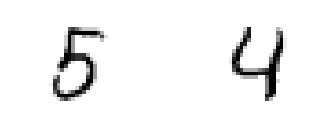

In [60]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

**Tip**: If plot fails please upgrade dask library.

!pip install dask --upgrade

Build scoring dictionary consisting of two digits and send it to deployed model to get predictions.

In [61]:
scoring_data = {'inputs': [image1, image2]}

In [62]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'classes': [5, 4]}


<HR>

<a id="summary"></a>
## 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to run experiments. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist in IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Wojciech Sobala**, Data Scientist in IBM

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.